In [1]:
# 모듈 로딩
# 토큰화 & 형태소 분석 모듈 ----------------------------------
from konlpy.tag import Okt
from collections import Counter

# 파이토치 모듈 ----------------------------------------------
import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader
from torch import optim
from torchmetrics.classification import MulticlassF1Score
import torch.optim.lr_scheduler as lr_scheduler
from torchmetrics.classification import BinaryAccuracy

# 데이터 전처리 & 로드 모듈 -----------------------------------
import re
import os
import pandas as pd
import numpy as np
import time
import matplotlib.pyplot as plt

# mysql -----------------------------------
import pymysql

# 개인 정리 모듈 
from flask_utils import *

In [2]:
# MySQL 연결 설정
connection = pymysql.connect(
    host= '172.20.60.151',      # MySQL 서버 주소
    user='jiwon',  
    password='1234',  
    db='web_project'
)

try:
    query = "SELECT id,category,text FROM pet"  
    df_pet = pd.read_sql(query, connection)
    
    query = "SELECT id,category,text FROM military"  
    df_army = pd.read_sql(query, connection)

finally:
    # 연결 종료
    connection.close()

C:\Users\KDP-43\AppData\Local\Temp\ipykernel_11048\4180556231.py:13: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df_pet = pd.read_sql(query, connection)
C:\Users\KDP-43\AppData\Local\Temp\ipykernel_11048\4180556231.py:16: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df_army = pd.read_sql(query, connection)


In [3]:
df_pet.head(5)

,id,category,text
0,0,반려동물,동물 키워도 털 하나 안 날릴 자신 있어
1,1,반려동물,동물 털 들어간 애 들 안 키운다고 안 받아 나로 충분해
2,2,반려동물,말티 푸 말티 푸 말티 푸 너무 너무 너무 너무 키우고 싶어 진짜루
3,3,반려동물,하긴 운 털 많이 날리 기는 하는데
4,4,반려동물,날리는 게 아니라 다리 털 많아서 한 거야


In [4]:
df_army.head(5)

,id,category,text
0,0,군대,군인 들 은 산재 처리 되나
1,1,군대,엄청 많이 다치잖아
2,2,군대,군인 들 은 나라 사랑 카드 발급 받으면 최대 만원 까지 보험 처리 되는데 죽어야 ...
3,3,군대,군인 산재 어딨냐 걍 국군 병원 고고 지
4,4,군대,죽어야 나중 아들 낳으면 꽁꽁 숨겨 놔야지 안되겠어


In [5]:
totDF = pd.concat([df_pet, df_army])
totDF['category'].value_counts()

category
군대      55017
반려동물    53225
Name: count, dtype: int64

In [6]:
totDF['label'] = totDF['category'].apply(
    lambda x: int(1) if x=='반려동물' 
    else int(0) if x == '군대' else 2 )
totDF.info()

<class 'pandas.core.frame.DataFrame'>
Index: 108242 entries, 0 to 55016
Data columns (total 4 columns):
 #   Column    Non-Null Count   Dtype 
---  ------    --------------   ----- 
 0   id        108242 non-null  int64 
 1   category  108242 non-null  object
 2   text      108242 non-null  object
 3   label     108242 non-null  int64 
dtypes: int64(2), object(2)
memory usage: 4.1+ MB


In [7]:
tmpDF = totDF.copy()
tmpDF = tmpDF.reset_index(drop=True)
train = tmpDF.sample(frac=0.8, random_state=42)
valid = tmpDF.drop(train.index)

# 확인
print(f"Train Data Size: {len(train)}")
print(f"Valid Data Size: {len(valid)}")

Train Data Size: 86594
Valid Data Size: 21648


In [8]:
# 불용어 처리 데이터 로드
STOP_FILE = './kor_stopwordsVer2.txt'

kor_stopwords = clean_korStopwords(STOP_FILE)
kor_stopwords.append('키키')
kor_stopwords.append('는')
kor_stopwords.append('은')

In [9]:
# 토크나이저 인스턴스 생성
tokenizer = Okt()

# 토큰화
train_tokens = [
    [token for token in tokenizer.morphs(text) if token not in kor_stopwords] for text in train.text
]

valid_tokens = [
    [token for token in tokenizer.morphs(text) if token not in kor_stopwords] for text in valid.text
]

vocab = build_vocab(corpus=train_tokens, n_vocab=5000, special_tokens=["<pad>","<unk>"])
token_to_id = {token: idx for idx, token in enumerate(vocab)}
it_to_token = {idx: token for idx, token in enumerate(vocab)}

print(vocab[:10])
print(len(vocab))

['<pad>', '<unk>', '군대', '안', '거', '강아지', '잘', '고양이', '너무', '많이']
5002


In [10]:
# 단어 사전 저장
import pickle
with open('./pet_vocab.pkl', 'wb') as f:
	pickle.dump(token_to_id, f)

print("단어 사전이 저장되었습니다.")

단어 사전이 저장되었습니다.


(array([5.4128e+04, 3.0066e+04, 2.1930e+03, 1.6900e+02, 2.8000e+01,
        6.0000e+00, 3.0000e+00, 1.0000e+00]),
 array([ 0.  ,  5.75, 11.5 , 17.25, 23.  , 28.75, 34.5 , 40.25, 46.  ]),
 <BarContainer object of 8 artists>)

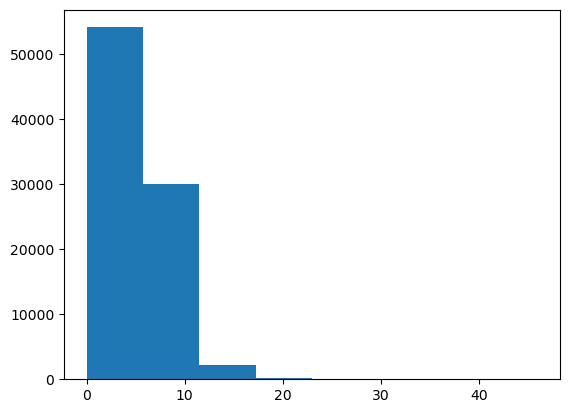

In [11]:
# 패딩 적정 길이 찾기
datalen = [len(tokens) for tokens in train_tokens]
plt.hist(datalen, bins=8)

(array([ 3959., 20813., 29356., 18507.,  8225.,  3334.,  1377.,   576.,
          240.,   131.]),
 array([ 0.,  2.,  4.,  6.,  8., 10., 12., 14., 16., 18., 20.]),
 <BarContainer object of 10 artists>)

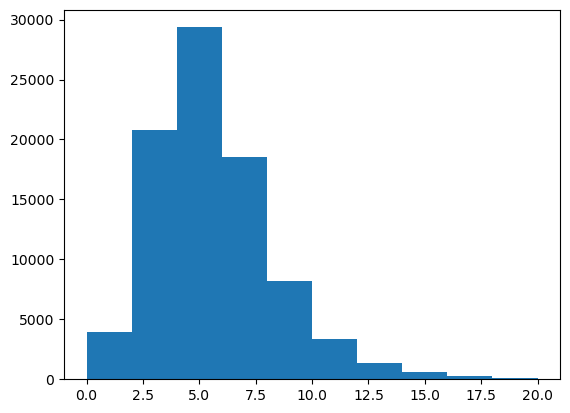

In [12]:
datalen = [len(tokens) for tokens in train_tokens]
datalen_100 = [len(tokens) for tokens in train_tokens if len(tokens) <= 20 ]
plt.hist(datalen_100, bins=10)

In [13]:
# 정수 인코딩 & 패딩
unk_id = token_to_id["<unk>"]

train_ids = [
	[token_to_id.get(token, unk_id) for token in review] for review in train_tokens
]

valid_ids = [
	[token_to_id.get(token, unk_id) for token in review] for review in valid_tokens
]

max_length = 20
pad_id = token_to_id["<pad>"]
train_ids = pad_sequences(train_ids, max_length, pad_id)
valid_ids = pad_sequences(valid_ids, max_length, pad_id)

print(train_ids[0])
print(valid_ids[0])

[271 506  17   1   1   4  12   0   0   0   0   0   0   0   0   0   0   0
   0   0]
[3600  397 3600  397 3600  397    8    8    8    8   62  100    1    0
    0    0    0    0    0    0]


In [14]:
# 데이터 로더 적용
train_ids = torch.tensor(train_ids)
valid_ids = torch.tensor(valid_ids)

train_labels = torch.tensor(train.label.values, dtype=torch.float32)
valid_labels = torch.tensor(valid.label.values, dtype=torch.float32)

train_DS = TensorDataset(train_ids, train_labels)
valid_DS = TensorDataset(valid_ids, valid_labels)

train_loader = DataLoader(train_DS, batch_size=64, shuffle=True)
valid_loader = DataLoader(valid_DS, batch_size=64, shuffle=False)

In [15]:
# 모델 파라미터 정의
n_vocab = len(token_to_id)
hidden_dim = 8
embedding_dim = 128
n_layers = 2
model_type = "gru"

pos_weight = torch.FloatTensor([totDF['label'].value_counts()[1] / totDF['label'].value_counts()[0]])
device = "cuda" if torch.cuda.is_available() else "cpu"

classifier = SentenceClassifier(
    n_vocab=n_vocab, hidden_dim=hidden_dim, embedding_dim=embedding_dim, n_layers=n_layers
).to(device)
lossFunc = nn.BCEWithLogitsLoss(pos_weight=pos_weight).to(device)
optimizer = optim.RMSprop(classifier.parameters(), lr=0.001)
scoreFunc = BinaryAccuracy().to(device)
scheduler = lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', patience=5, verbose=True) # score 사용 시

# optimizer = optim.Adam(classifier.parameters(), lr=0.001	)

c:\Users\KDP-43\anaconda3\envs\TEXT_018_230_38\lib\site-packages\torch\optim\lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "


----------
Epoch 1/20
----------
Epoch 1/20
Train Loss: 0.5663 | Train Acc: 0.6583
Valid Loss: 0.4133 | Valid Acc: 0.7797
scheduler.num_bad_epochs => 0 scheduler.patience => 5
----------
Epoch 2/20
----------
Epoch 2/20
Train Loss: 0.3872 | Train Acc: 0.8018
Valid Loss: 0.3565 | Valid Acc: 0.8051
scheduler.num_bad_epochs => 1 scheduler.patience => 5
----------
Epoch 3/20
----------
Epoch 3/20
Train Loss: 0.3397 | Train Acc: 0.8248
Valid Loss: 0.3479 | Valid Acc: 0.8103
scheduler.num_bad_epochs => 2 scheduler.patience => 5
----------
Epoch 4/20
----------
Epoch 4/20
Train Loss: 0.3169 | Train Acc: 0.8361
Valid Loss: 0.3307 | Valid Acc: 0.8199
scheduler.num_bad_epochs => 3 scheduler.patience => 5
----------
Epoch 5/20
----------
Epoch 5/20
Train Loss: 0.3030 | Train Acc: 0.8445
Valid Loss: 0.3395 | Valid Acc: 0.8103
scheduler.num_bad_epochs => 4 scheduler.patience => 5
----------
Epoch 6/20
----------
Epoch 6/20
Train Loss: 0.2945 | Train Acc: 0.8473
Valid Loss: 0.3359 | Valid Acc: 0.815

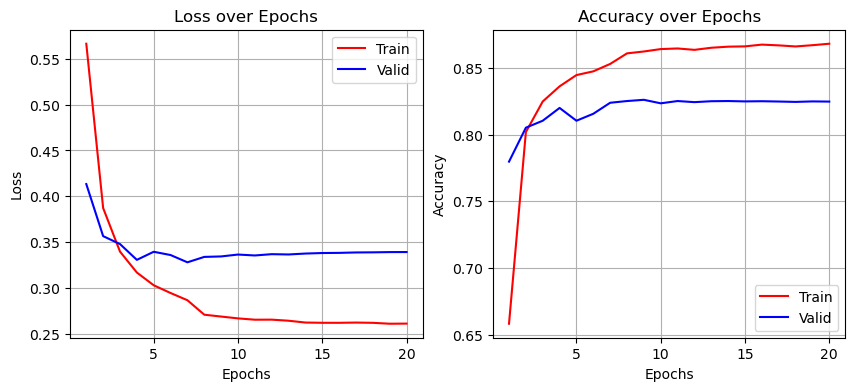

In [16]:
trainval_Binary(classifier, train_loader, valid_loader, lossFunc, scoreFunc, optimizer, device, scheduler, num_epochs=20)